<a href="https://colab.research.google.com/github/Callanmix/Working-With-GANs/blob/main/Simple_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np, pandas as pd
import os
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import imageio
import glob

## Define Basic Varibles

In [2]:
n_samples = 10000 #@param {type:"slider", min:1000, max:50000, step:1000}

batch_size = 256 #@param ["64", "128", "256", "512", "1024"] {type:"raw"}

latent_dim = 5 #@param {type:"slider", min:0, max:100, step:5}

epochs = 500 #@param {type:"slider", min:0, max:10000, step:500}

capture_epoch = int(round((epochs/40)/5.0)*5.0)

type_of_data = "linear" #@param ["parabolic", "cubic", "circular", "linear"] {type:"string"}


## Get Y Data Point from X Data Point
def get_y(x, type_ = "parabolic", m = 1, b = 0, sd = 0, mirror_data=False):
    """
    x:          X Data Point
    type_:      Distribution Type to copy
    m:          m of m * X + b
    b:          b of m * X + b
    sd:         Deviation of points from original distribution
    mirror_data:
            There may be a better way to do this (there has to be)
            We randomly flip the data. This means we can have a positive version
            and negative. For example positive and negative parabola
             [np.random.choice([-1,1]) if mirror_data == True else 1 for i in range(1)][0]
    """
    if type_.lower() == 'parabolic':
      return ((m * x**2 + b) + np.random.normal(scale=sd)) * [np.random.choice([-1,1]) if mirror_data == True else 1 for i in range(1)][0]

    elif type_.lower() == 'cubic':
      return ((m * x**3 + b) + np.random.normal(scale=sd)) * [np.random.choice([-1,1]) if mirror_data == True else 1 for i in range(1)][0]

    elif type_.lower() == 'circular':
      mirror_data = True
      return ((np.sqrt(4**2 - x**2)) + np.random.normal(scale=sd)) * [np.random.choice([-1,1]) if mirror_data == True else 1 for i in range(1)][0]

    elif type_.lower() == 'linear':
      return ((m * x + b) + np.random.normal(scale=sd)) * [np.random.choice([-1,1]) if mirror_data == True else 1 for i in range(1)][0]
    else:
      print('Please Choose from Following list of options: ["parabolic", "cubic", "circular", "linear"]')

    

def sample_data(n=10000, scale=100):
    """
    n:        Number of points to produce
    scale:    Make points X times bigger
    """
    data = []
    x = scale * (np.random.random_sample((n,)) -0.5)
    for i in range(n):
        yi = get_y(
            x[i],
            sd = .5,
            m = 4,
            b = 9,
            type_ = type_of_data,
            mirror_data = False
          )
        data.append([x[i], yi])
    ## On circle data some points return nan (we remove those)
    return np.array(data)[~np.isnan(np.array(data)).any(axis=1)]


data = sample_data(scale=10)

### Get a consistant sample to plot as we train (to generate gif at end)
plot_original_data = data[np.random.choice(data.shape[0], 200, replace=False), :]

### Make a dataset
data = tf.data.Dataset.from_tensor_slices(data,).shuffle(buffer_size=100).batch(batch_size = batch_size)

## Define Generator and Discriminator

In [3]:
def Discriminator():
  model = tf.keras.Sequential(name='disciminator')
  model.add(layers.Dense(25, activation='relu', input_shape=(2, )))
  model.add(layers.Dense(25, activation='relu'))
  model.add(layers.Dense(2))
  model.add(layers.Dense(1))
  return model

def Generator():
  model = tf.keras.Sequential(name='generator')
  model.add(layers.Dense(16, activation='relu', input_shape=(latent_dim, )))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(2))
  return model

## Instanciate and View Models

In [4]:
discriminator = Discriminator()
generator = Generator()

discriminator.summary()
generator.summary()

Model: "disciminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 52        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 780
Trainable params: 780
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                96        
_____________________________________

## Define Optimizers and Loss Functions

In [6]:
generator_optimizer = tf.keras.optimizers.Adam(.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(.0001)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_data, fake_data):
  real_loss = cross_entropy(tf.ones_like(real_data, dtype='float32') + tf.random.uniform((real_data.shape[0],1), minval=-1, maxval=1)*.05, real_data)
  fake_loss = cross_entropy(tf.zeros_like(fake_data, dtype='float32') + tf.random.uniform((fake_data.shape[0],1), minval=-1, maxval=1)*.05, fake_data)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_data):
  return cross_entropy(tf.ones_like(fake_data), fake_data)

## Define Train Step

In [7]:
@tf.function
def train_step(real_data):
  """
  real_data: a tf.dataset that has already been batched
  
  The train step starts by taking a getting a batch of random latent point to be fed into the generator.
  We then train the generator and discriminator. The real and fake batches are trained seperately
  The two outputs are fed into our loss functions to get a value for both networks
  
  tf.GradientTape keeps track of the forward pass in each network. We find the gradients and the make our 
  backward pass through each network hopefully minimizing the loss on the next pass through
  """
  random_sample_points = tf.random.normal((batch_size, latent_dim))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_data = generator(random_sample_points, training=True)

    real_output = discriminator(real_data, training=True)
    fake_output = discriminator(generated_data, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
  # Backward pass through each network
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss


def train(epochs = 20, save_images=False):
  for filepath in glob.iglob(r'/content/drive/My Drive/Colab Notebooks/GANS/Saved_Plots/*.png'):
    os.remove(filepath)

  gen_loss_list, disc_loss_list = [], []
  seed_points = tf.random.normal((batch_size, latent_dim))

  for epoch in range(epochs+1):
    for _, batch in enumerate(data):
      gen_loss, disc_loss = train_step(batch)
    gen_loss_list.append(gen_loss), disc_loss_list.append(disc_loss)

    generated_data_points = generator(seed_points, training = False)

    if epoch % capture_epoch == 0:
      print("{}/{} gen loss: {} - disc loss {}".format(epoch, epochs, gen_loss, disc_loss))
      plot_and_save(generated_data_points, plot_original_data, epoch, gen_loss_list, disc_loss_list, save_plot=save_images)

  return gen_loss_list, disc_loss_list


def plot_and_save(data, original, step, gen_list, disc_list, save_plot=False):
  plt.figure(figsize=(15,5))
  grid = plt.GridSpec(2, 6, wspace=0.5, hspace=0.3)

  plt.subplot(grid[0, 2:4])
  sns.histplot(original, kde=True, bins=50, stat='density')
  plt.legend(['X', 'Y'], loc = 'upper right')
  plt.title('Real Data Distribution')

  plt.subplot(grid[1, 2:4])
  sns.histplot(data.numpy(), kde=True, bins=50, stat='density')
  plt.legend(['X', 'Y'], loc = 'upper right')
  plt.title('Generated Data Distribution')
  plt.xlim((original.min(), original.max()))

  plt.subplot(grid[:2, :2], xticklabels=[], yticklabels=[])
  sns.scatterplot(x = [x[0] for x in original], y = [y[1] for y in original])
  sns.scatterplot(x = [x[0] for x in data.numpy()], y = [y[1] for y in data.numpy()], alpha=.6)
  plt.legend(['Original Points', 'Generated Points'], loc = 'upper left')
  plt.title('Epoch: {}'.format(step), loc='left')

  plt.subplot(grid[:2, 4:])
  plt.plot(range(len(gen_list)), gen_list)
  plt.plot(range(len(disc_list)), disc_list)
  plt.legend(['Generator Loss', 'Discriminator Loss'])
  plt.title('Measuring Loss Over Time', loc='left')
  
  if save_plot:
    plt.savefig('/content/drive/My Drive/Colab Notebooks/GANS/Saved_Plots/{}.png'.format(step))

  plt.show()




## Run Training

0/500 gen loss: 0.6848671436309814 - disc loss 1.1339691877365112


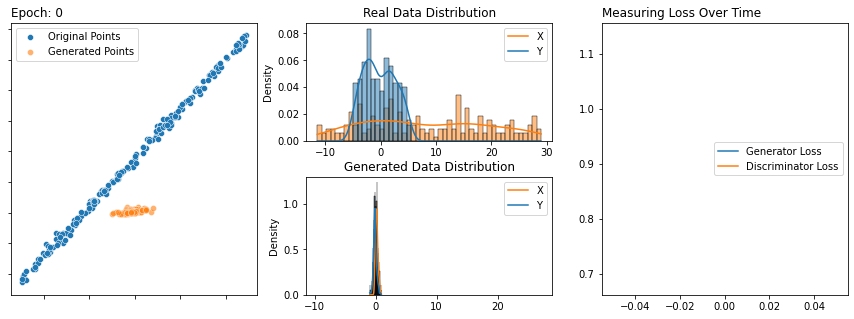

10/500 gen loss: 0.8844138383865356 - disc loss 0.6272032260894775


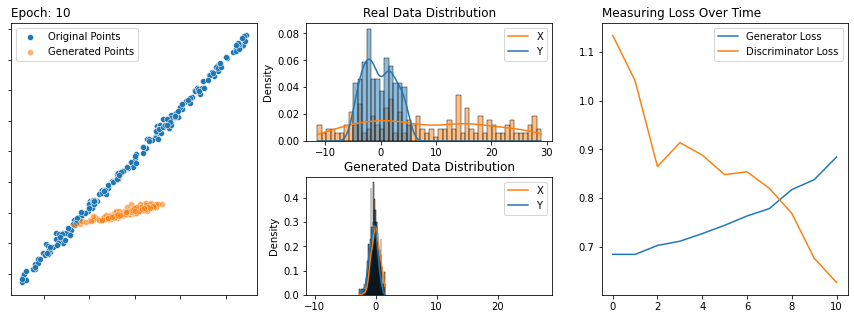

20/500 gen loss: 1.275886058807373 - disc loss 0.817551851272583


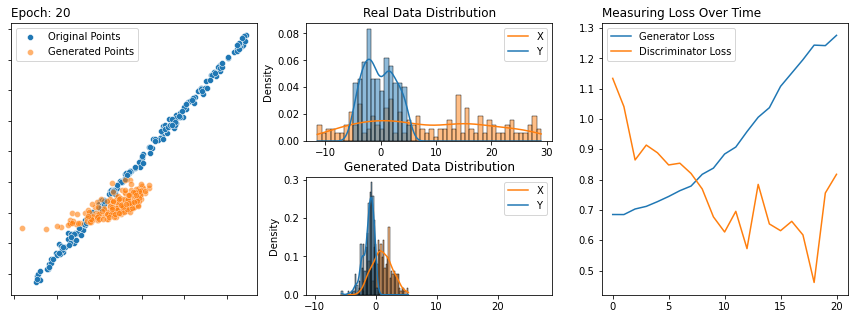

30/500 gen loss: 1.4487314224243164 - disc loss 0.7199900150299072


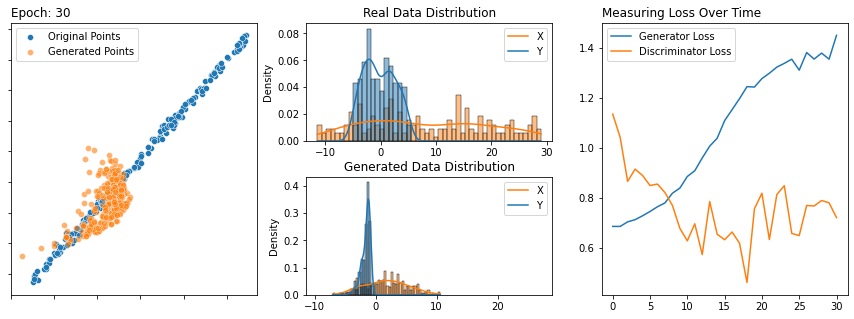

40/500 gen loss: 1.1810798645019531 - disc loss 1.0092692375183105


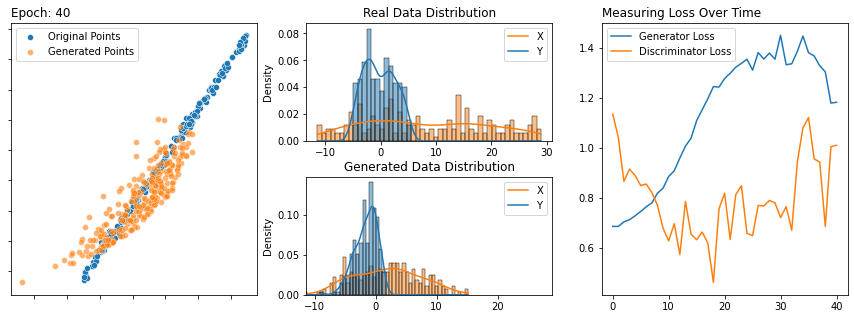

50/500 gen loss: 1.0220017433166504 - disc loss 1.1172504425048828


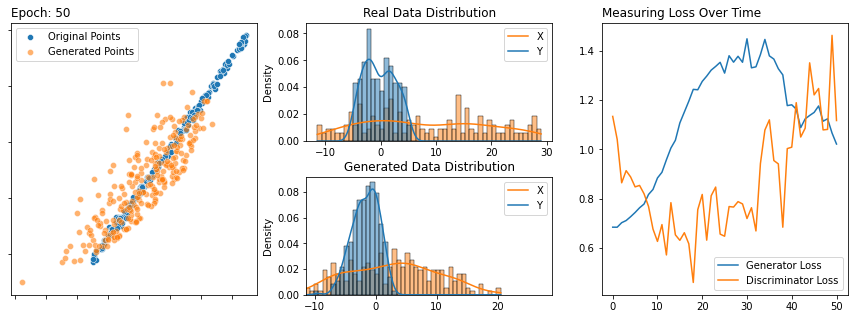

60/500 gen loss: 0.8578315377235413 - disc loss 1.3379170894622803


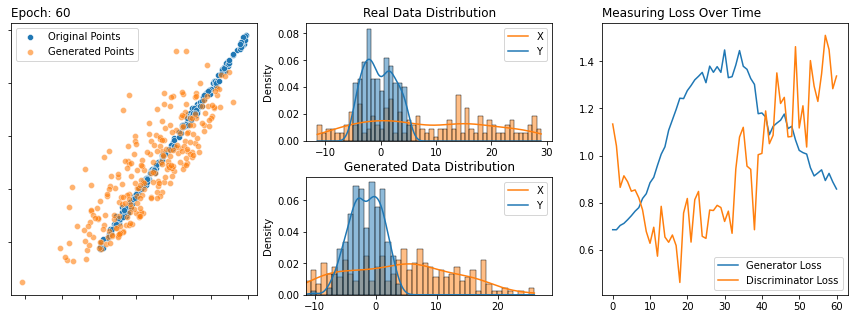

70/500 gen loss: 0.8518915772438049 - disc loss 1.3604564666748047


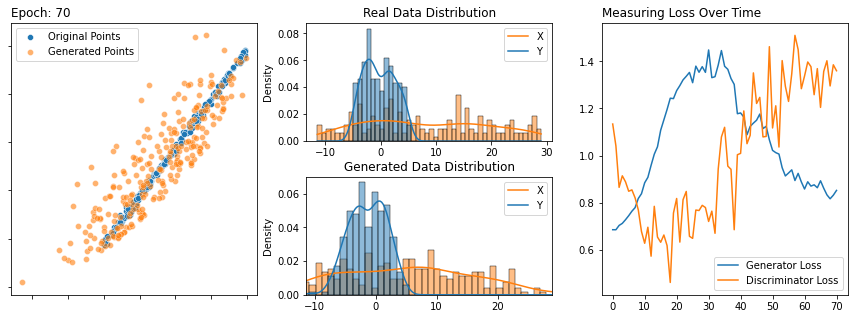

80/500 gen loss: 0.7754091024398804 - disc loss 1.3681843280792236


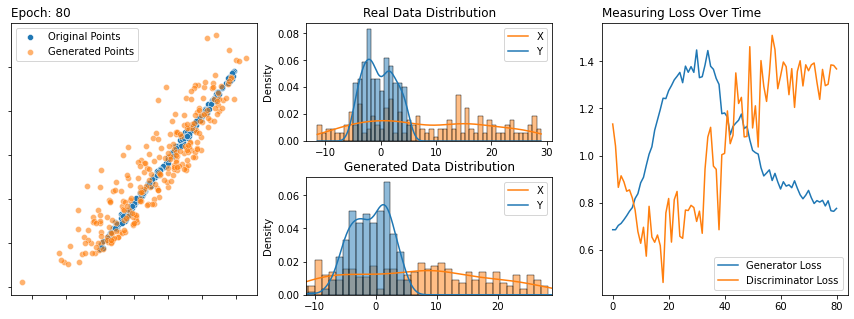

90/500 gen loss: 0.7162708044052124 - disc loss 1.3415207862854004


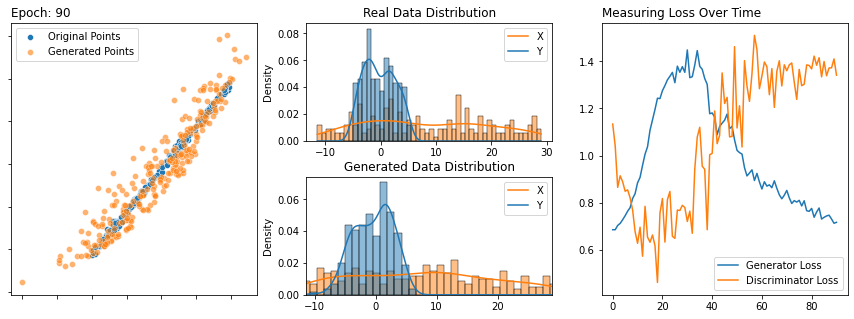

100/500 gen loss: 0.6930302977561951 - disc loss 1.3854862451553345


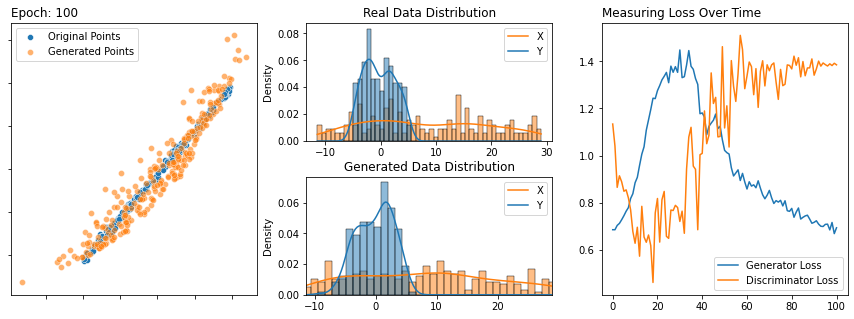

110/500 gen loss: 0.6890663504600525 - disc loss 1.390684962272644


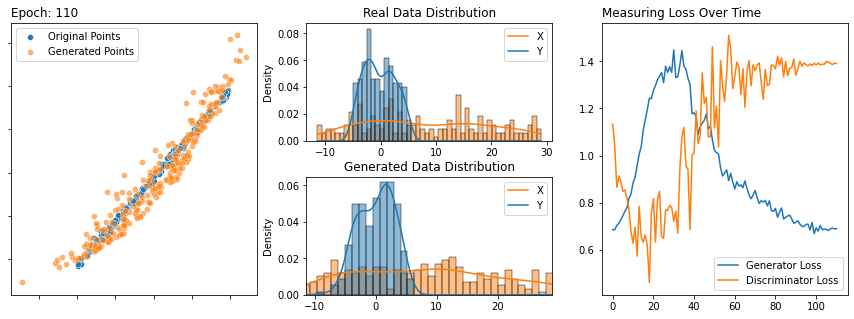

120/500 gen loss: 0.7021614909172058 - disc loss 1.389764428138733


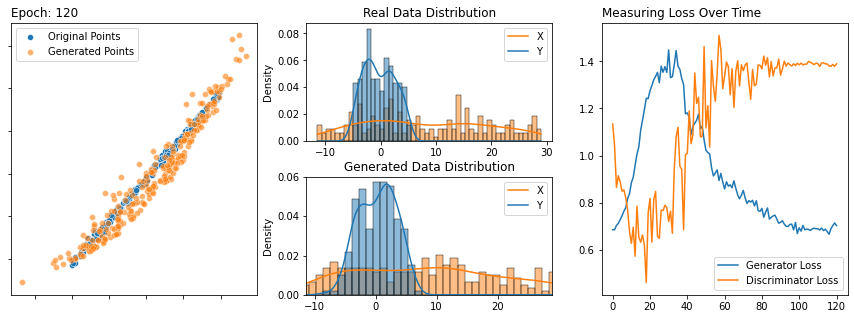

130/500 gen loss: 0.7309226989746094 - disc loss 1.3496429920196533


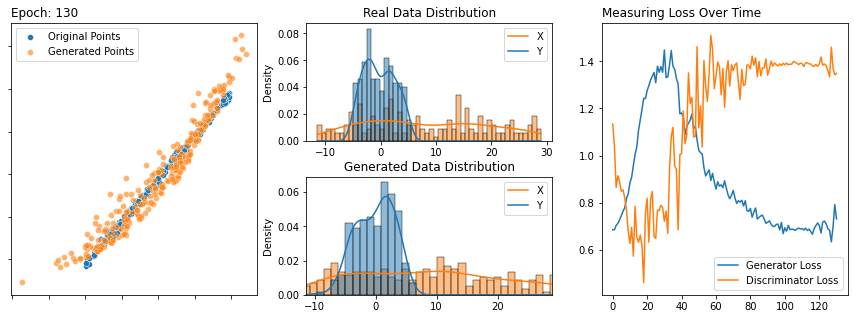

140/500 gen loss: 0.6675123572349548 - disc loss 1.4018045663833618


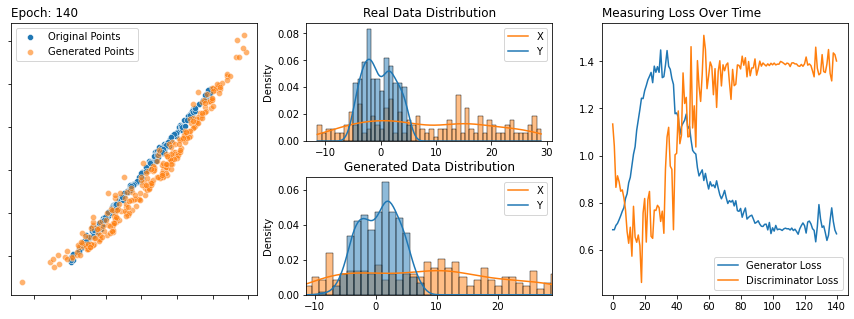

150/500 gen loss: 0.6873985528945923 - disc loss 1.340540885925293


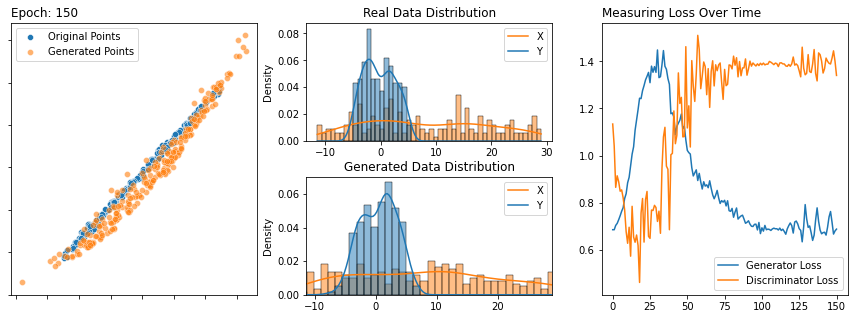

160/500 gen loss: 0.6740283966064453 - disc loss 1.3593766689300537


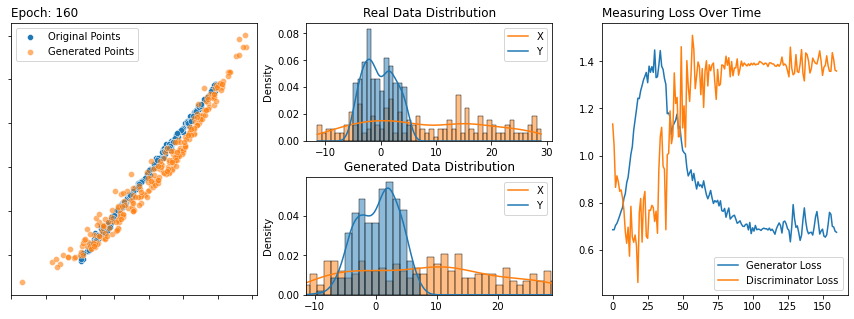

170/500 gen loss: 0.6860329508781433 - disc loss 1.392458200454712


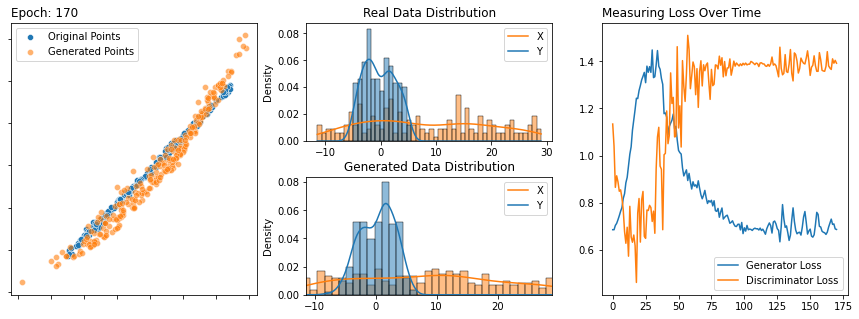

180/500 gen loss: 0.7070421576499939 - disc loss 1.3799277544021606


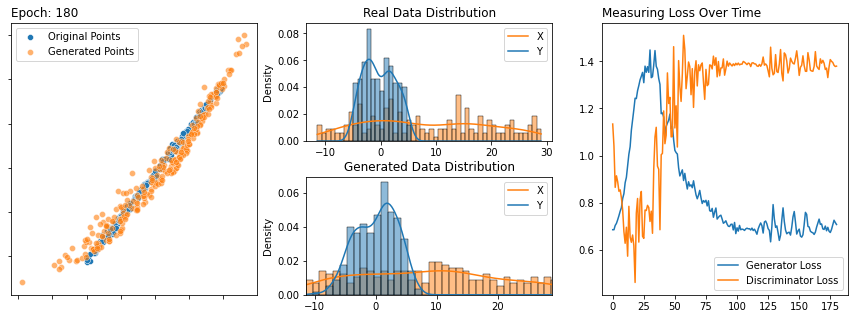

190/500 gen loss: 0.7066710591316223 - disc loss 1.4016741514205933


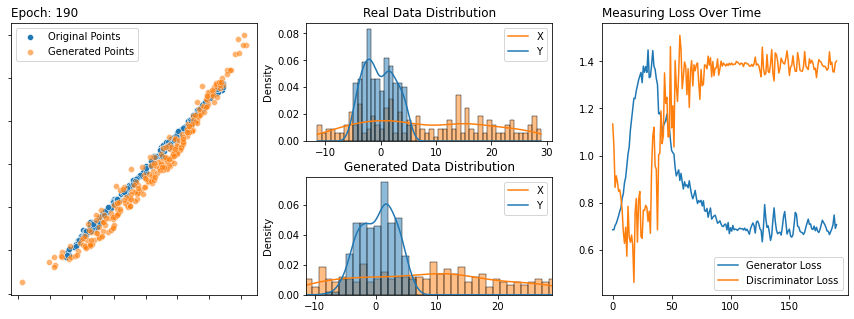

200/500 gen loss: 0.6817076802253723 - disc loss 1.4047151803970337


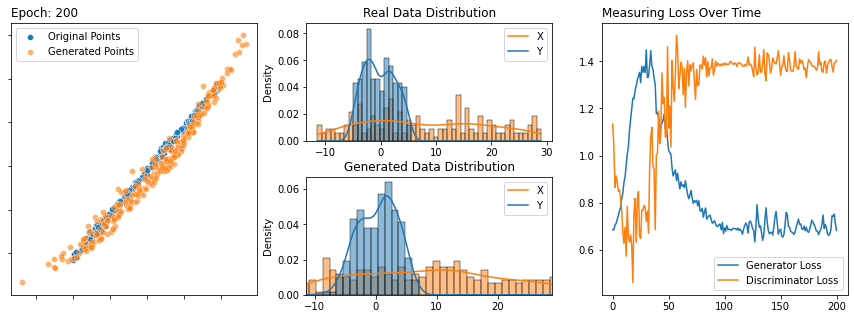

210/500 gen loss: 0.6938843727111816 - disc loss 1.399010181427002


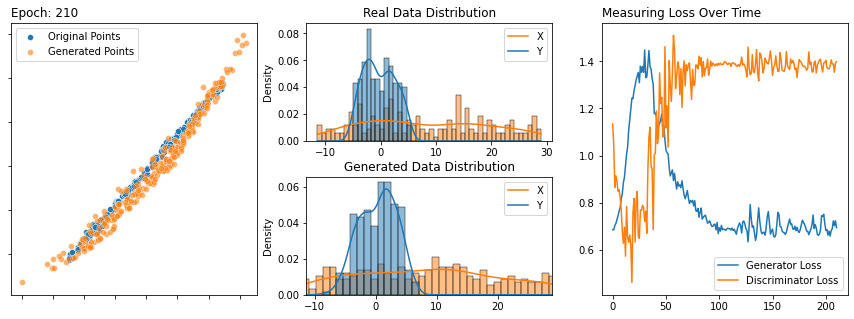

220/500 gen loss: 0.686417818069458 - disc loss 1.3946208953857422


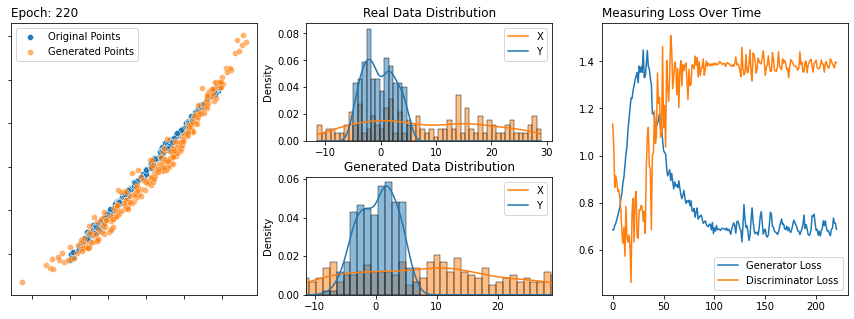

230/500 gen loss: 0.6792813539505005 - disc loss 1.3859615325927734


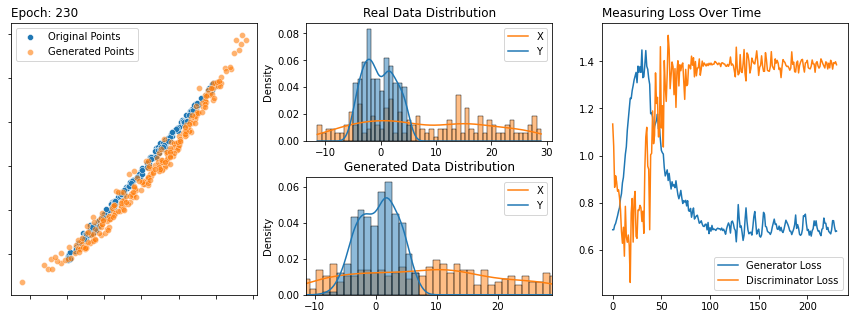

240/500 gen loss: 0.6621006727218628 - disc loss 1.4055745601654053


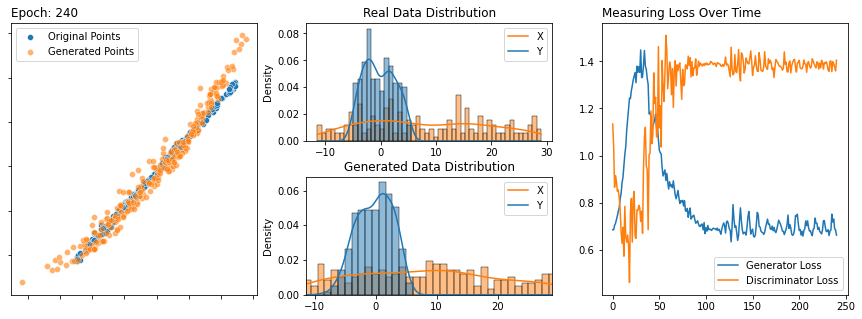

250/500 gen loss: 0.7176320552825928 - disc loss 1.3893063068389893


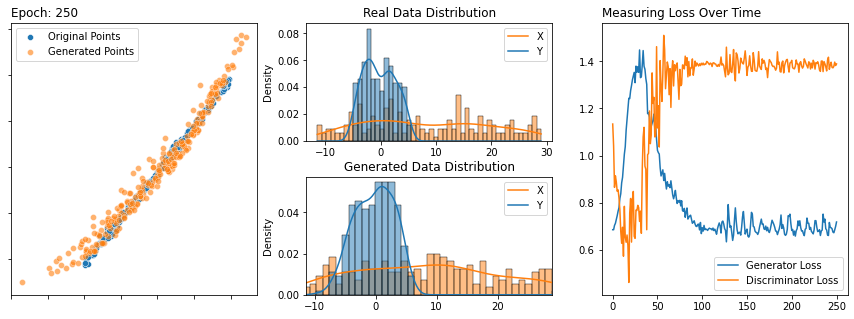

260/500 gen loss: 0.6946863532066345 - disc loss 1.3777177333831787


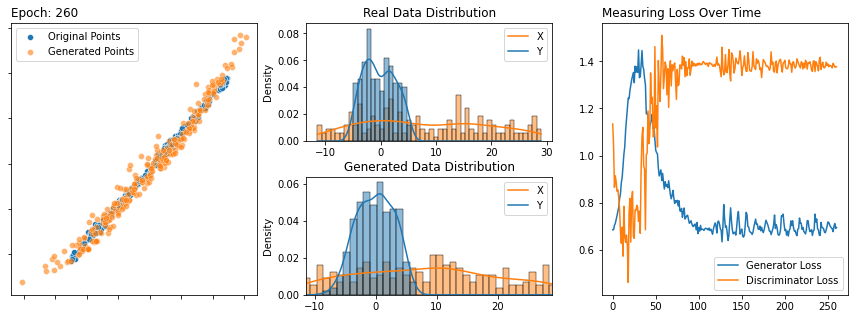

270/500 gen loss: 0.6962273120880127 - disc loss 1.3787829875946045


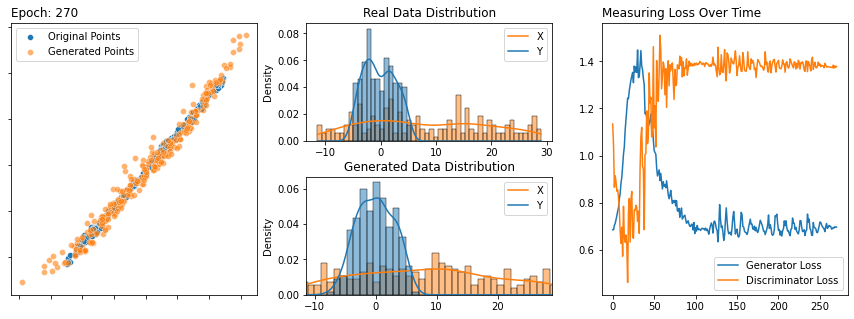

280/500 gen loss: 0.6887946128845215 - disc loss 1.377551794052124


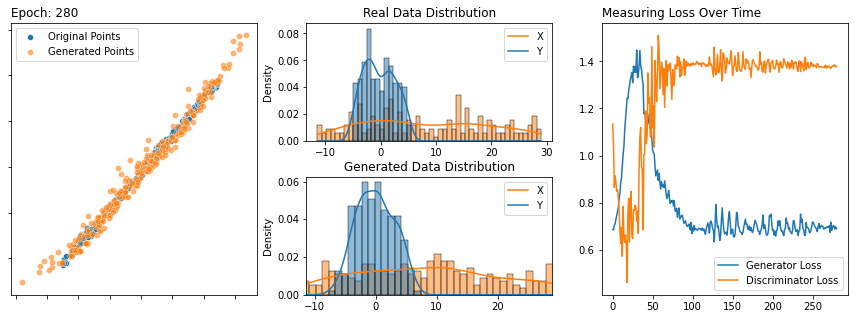

290/500 gen loss: 0.6832544803619385 - disc loss 1.3803642988204956


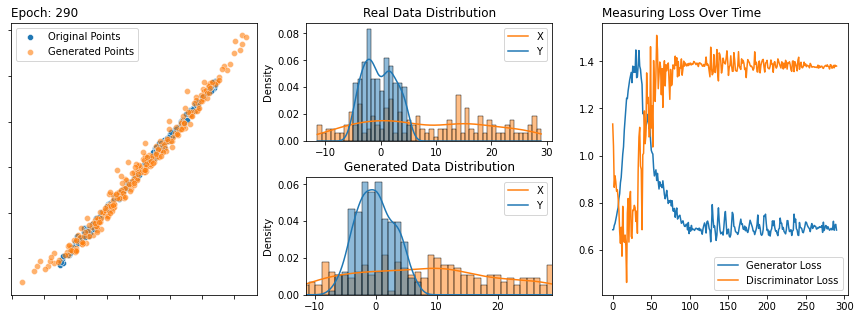

300/500 gen loss: 0.7089051008224487 - disc loss 1.3811109066009521


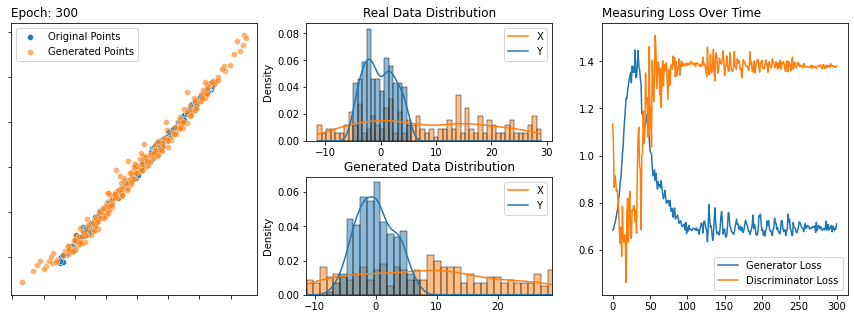

310/500 gen loss: 0.7067323327064514 - disc loss 1.3817520141601562


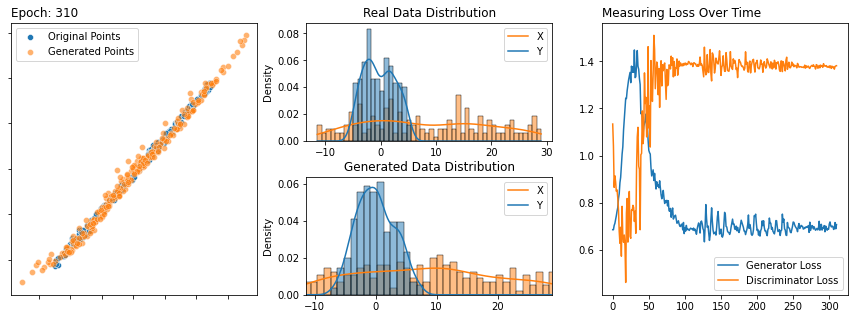

320/500 gen loss: 0.6832990646362305 - disc loss 1.4171974658966064


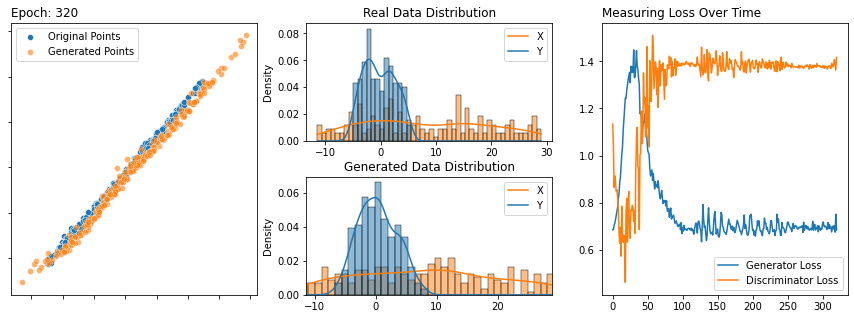

330/500 gen loss: 0.6712253093719482 - disc loss 1.3800641298294067


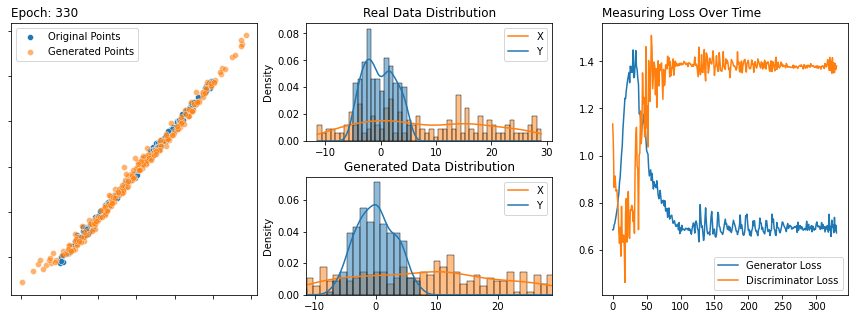

340/500 gen loss: 0.7064104080200195 - disc loss 1.376603603363037


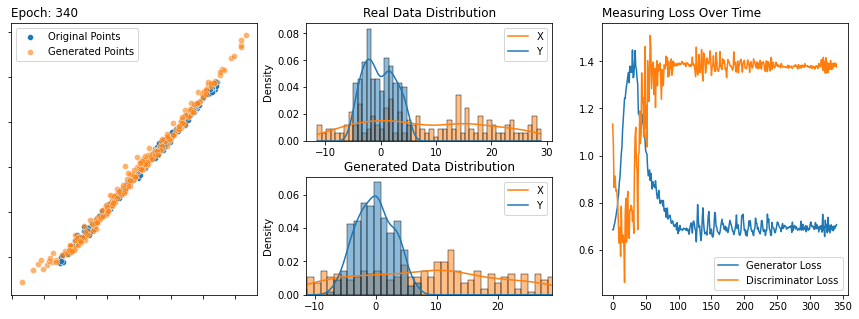

350/500 gen loss: 0.6885907649993896 - disc loss 1.3885812759399414


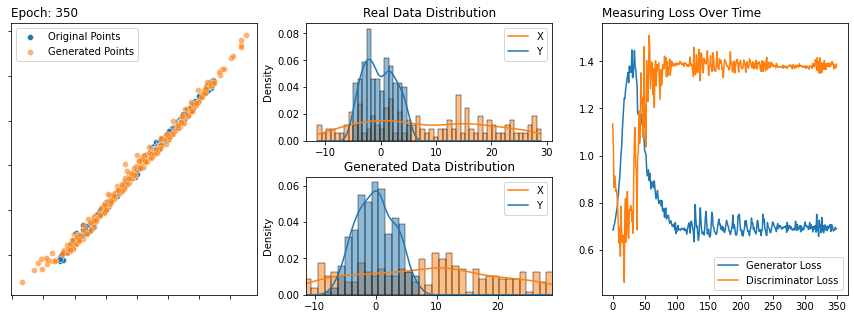

360/500 gen loss: 0.6931018829345703 - disc loss 1.4031686782836914


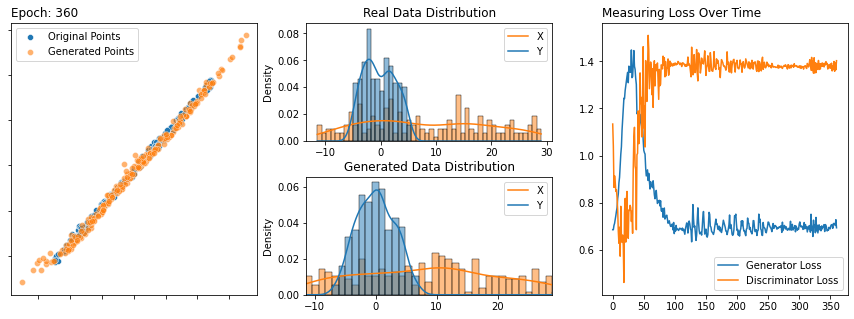

370/500 gen loss: 0.6828016042709351 - disc loss 1.3988726139068604


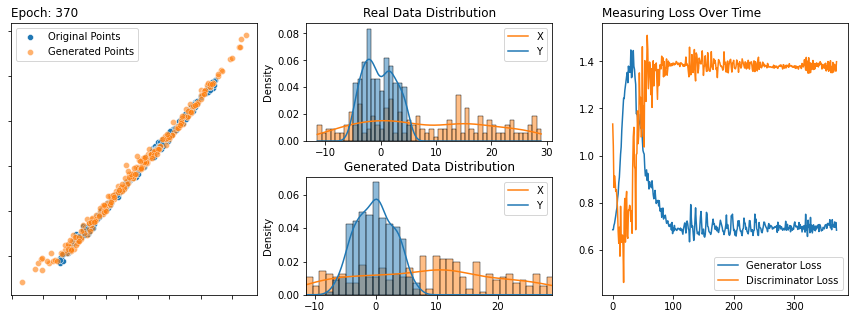

380/500 gen loss: 0.7023389935493469 - disc loss 1.3690955638885498


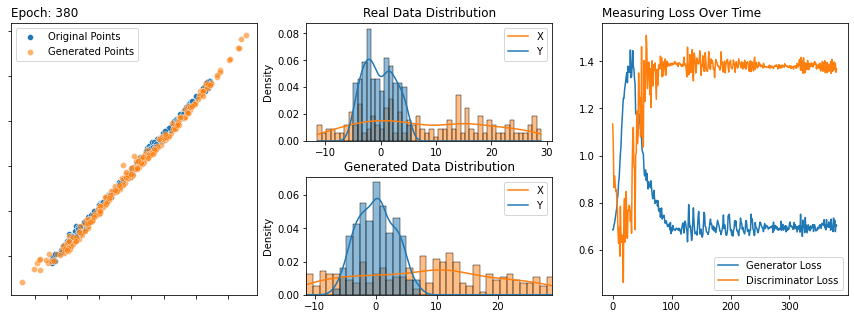

390/500 gen loss: 0.6998790502548218 - disc loss 1.3729695081710815


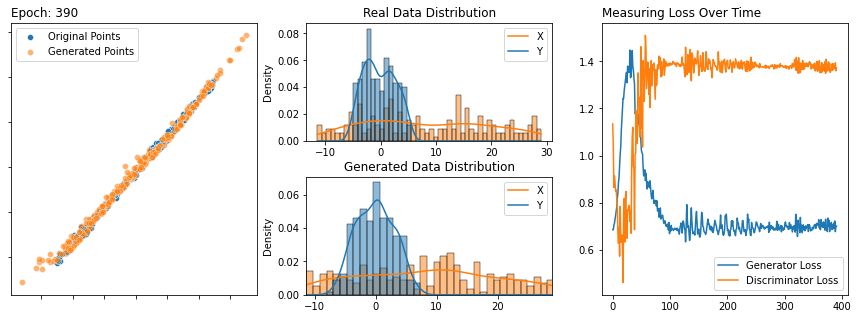

400/500 gen loss: 0.7014325857162476 - disc loss 1.3618924617767334


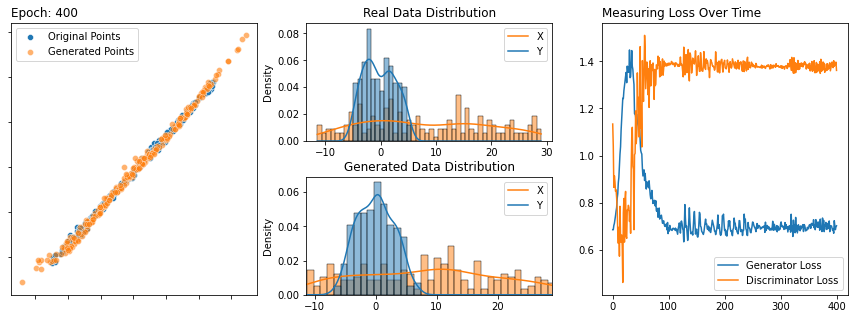

410/500 gen loss: 0.6975870728492737 - disc loss 1.3761111497879028


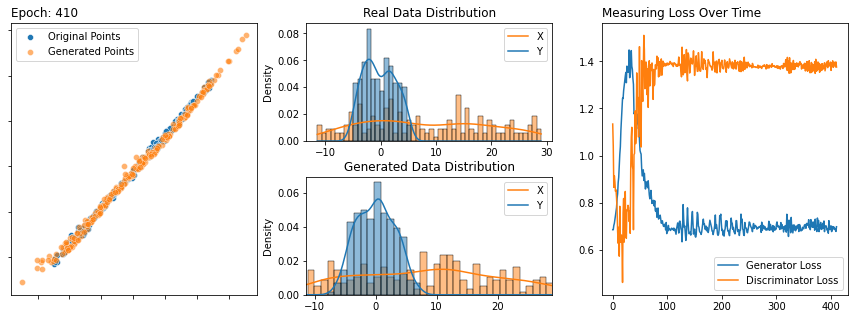

420/500 gen loss: 0.7057616710662842 - disc loss 1.3708362579345703


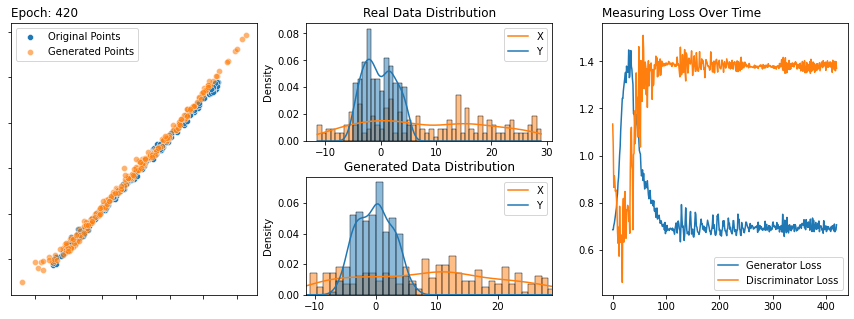

430/500 gen loss: 0.7029308676719666 - disc loss 1.356623649597168


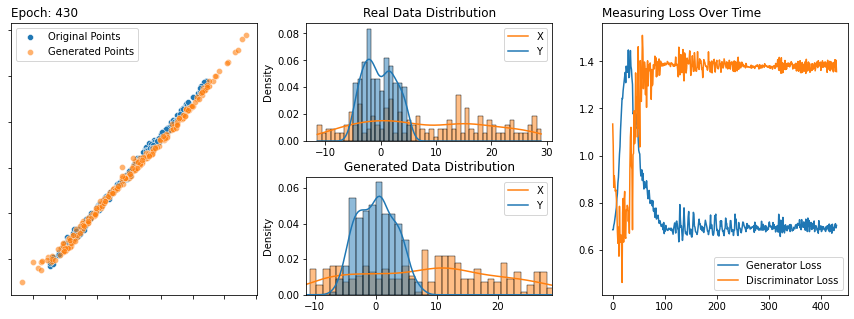

440/500 gen loss: 0.7083170413970947 - disc loss 1.3577733039855957


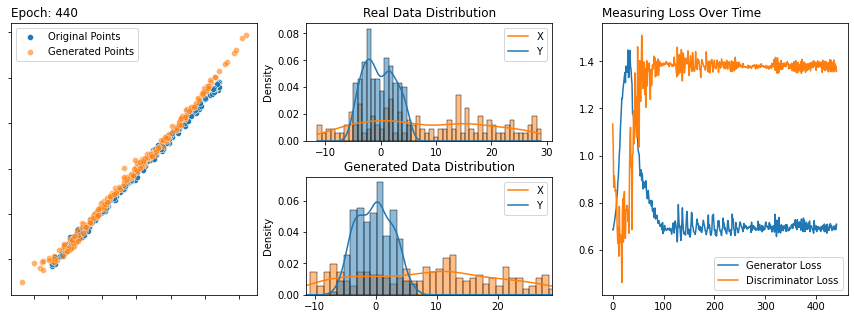

450/500 gen loss: 0.7077212333679199 - disc loss 1.399120807647705


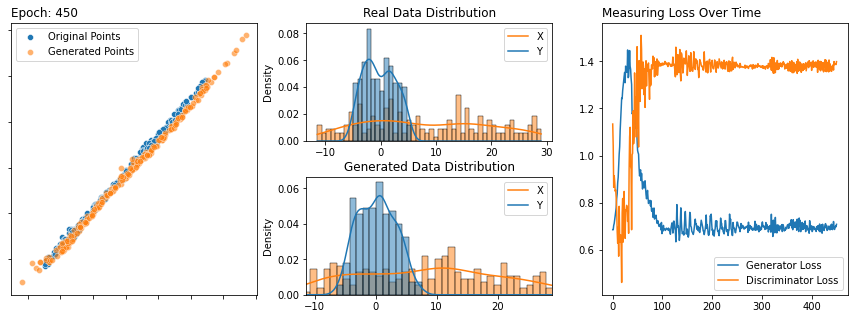

460/500 gen loss: 0.6744545698165894 - disc loss 1.4066805839538574


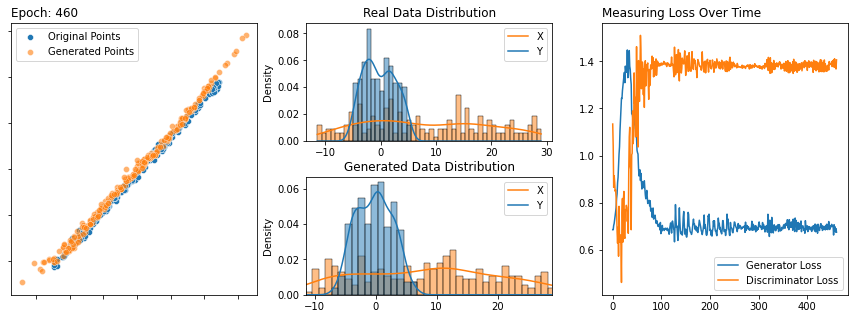

470/500 gen loss: 0.6953867077827454 - disc loss 1.3924689292907715


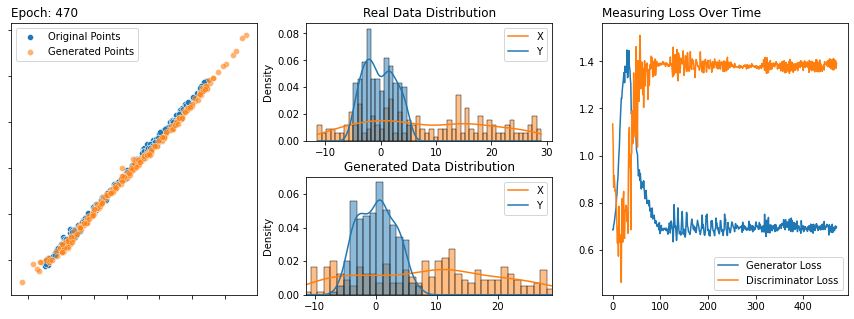

480/500 gen loss: 0.6944549679756165 - disc loss 1.3964526653289795


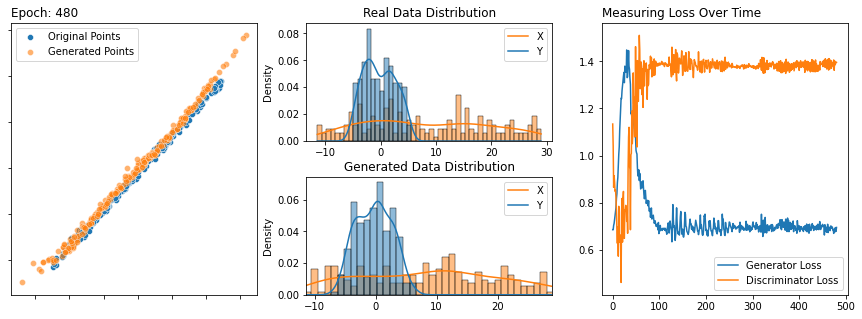

490/500 gen loss: 0.6785943508148193 - disc loss 1.4009696245193481


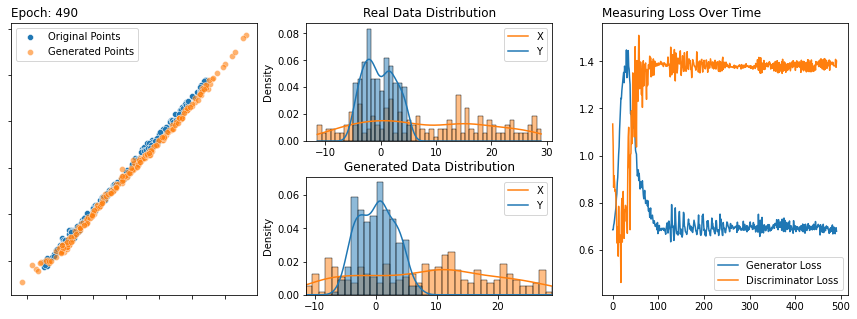

500/500 gen loss: 0.7171216607093811 - disc loss 1.3854258060455322


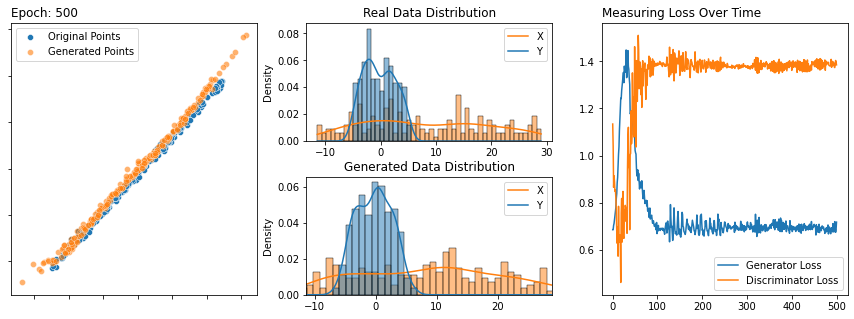

In [8]:
gen_loss_list, disc_loss_list = train(epochs)

## Create GIF Code

In [ ]:
image_path = Path('/content/drive/My Drive/Colab Notebooks/GANS/Saved_Plots')
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))

imageio.mimwrite('/content/drive/My Drive/Colab Notebooks/GANS/GAN GIFs/circular.gif', image_list, fps=3)